# Usage of sym_msm package

`MSMInitializer` base class to load the trajectory features,
running feature decomposition (e.g. for symTICA, `decomposition.SymTICAInitializer`), clustering, and build Markov state model.

**Note**: This notebook is a demonstration of the usage of the `sym_msm` package. Please refer to https://zenodo.org/records/8424868 **analysis-MS_symtica_apo.ipynb** that were used to generate the data.a

In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from pandas import DataFrame

import pyemma

%matplotlib inline
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
sns.set_style("ticks")
sns.set_context(font_scale=1,context='paper')
sns.set_context({"figure.figsize": (12, 12)})

import prettypyplot as pplt
pplt.use_style(cmap='bownair', latex=False)

from ENPMDA import MDDataFrame
from sym_msm.util.plotly_fes import generate_tica_csv, export_plotly
from sym_msm.decomposition import TICAInitializer, SymTICAInitializer

<Figure size 1152x711.975 with 0 Axes>

## Step.1 Load Data
Load MDDataFrame that contains metadata and trajectories

In [2]:
md_dataframe = MDDataFrame.load_dataframe('./a7_apos_feature/a7_apo_features_md_dataframe.pickle')

Loading ./a7_apos_feature/a7_apo_features_md_dataframe.pickle


## Step.2 SYMTICA
Initialize MSM object with SymTICA

In [3]:
# lag time = lag time * dt ns
updating = False
lag=50
start=100
msm_obj = SymTICAInitializer(
                         md_dataframe=md_dataframe,
                         lag=lag,
                         start=start,
                         multimer=5,
                         end=-1,
                         system_exclusion=[],
                         updating=updating,
                         in_memory=False
                         )

lag time is 50.0 ns
start time is 100.0 ns


In [4]:
start_seed_index = msm_obj.md_dataframe.dataframe[    
    (msm_obj.md_dataframe.dataframe.seed == 0) & 
    (msm_obj.md_dataframe.dataframe.frame == 0) &
    (msm_obj.md_dataframe.dataframe.ensemble == 'PRODUCTION')].system.unique()

start_seed_pathways = msm_obj.md_dataframe.dataframe[    
    (msm_obj.md_dataframe.dataframe.seed == 0) & 
    (msm_obj.md_dataframe.dataframe.frame == 0) &
    (msm_obj.md_dataframe.dataframe.ensemble == 'PRODUCTION')].pathway.unique()

start_seed_strucs = [pathway.split('_')[0] for pathway in start_seed_pathways]

print('start_seed_index', start_seed_index)
print('start_seed_pathways', start_seed_pathways)

start_seed_index [0 24 48 73 97 121]
start_seed_pathways ['BGT_EPJPNU' 'BGT_EPJ' 'EPJPNU_BGT' 'EPJPNU_EPJ' 'EPJ_BGT' 'EPJ_EPJPNU']


Select features to construct MSM

In [5]:
feat_info = md_dataframe.get_feature_info('ca_distance_10A_2diff')
resids_exclusion = list(range(267, 402)) + list(range(1,25)) + list(range(60, 75))
feat_ind_exclusion = []
feat_ind_inclusion = []
for ind, feat in enumerate(feat_info):
    resid1 = eval(feat.split('_')[1])
    resid2 = eval(feat.split('_')[3])
    if resid1 in resids_exclusion or resid2 in resids_exclusion:
        feat_ind_exclusion.append(ind)
    else:
        feat_ind_inclusion.append(ind)

In [6]:
msm_obj.add_feature('ca_distance_10A_2diff_reciprocal',
                    excluded_indices=feat_ind_exclusion,
                    feat_type='subunit')

msm_obj.start_analysis()
tica_concatenated = msm_obj.tica_concatenated
tica_output = msm_obj.tica_output
tica_subunit_output = msm_obj.tica_subunit_output
tica_subunit_concatenated = msm_obj.tica_subunit_concatenated
tica_model_tica = msm_obj.tica.fetch_model()
print(tica_concatenated.shape)

added feature selection ca_distance_10A_2diff_reciprocal type: subunit, # of features: 1610
Load old sym TICA results


/nethome/yzhuang/anaconda3/envs/msm_manuscript/lib/python3.10/site-packages/deeptime/base.py:116: UserWarning: Trying to unpickle estimator CovarianceModel from version 0.4.4 when using version 0.4.4+6.ga6ac0b9. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


(199763, 74)


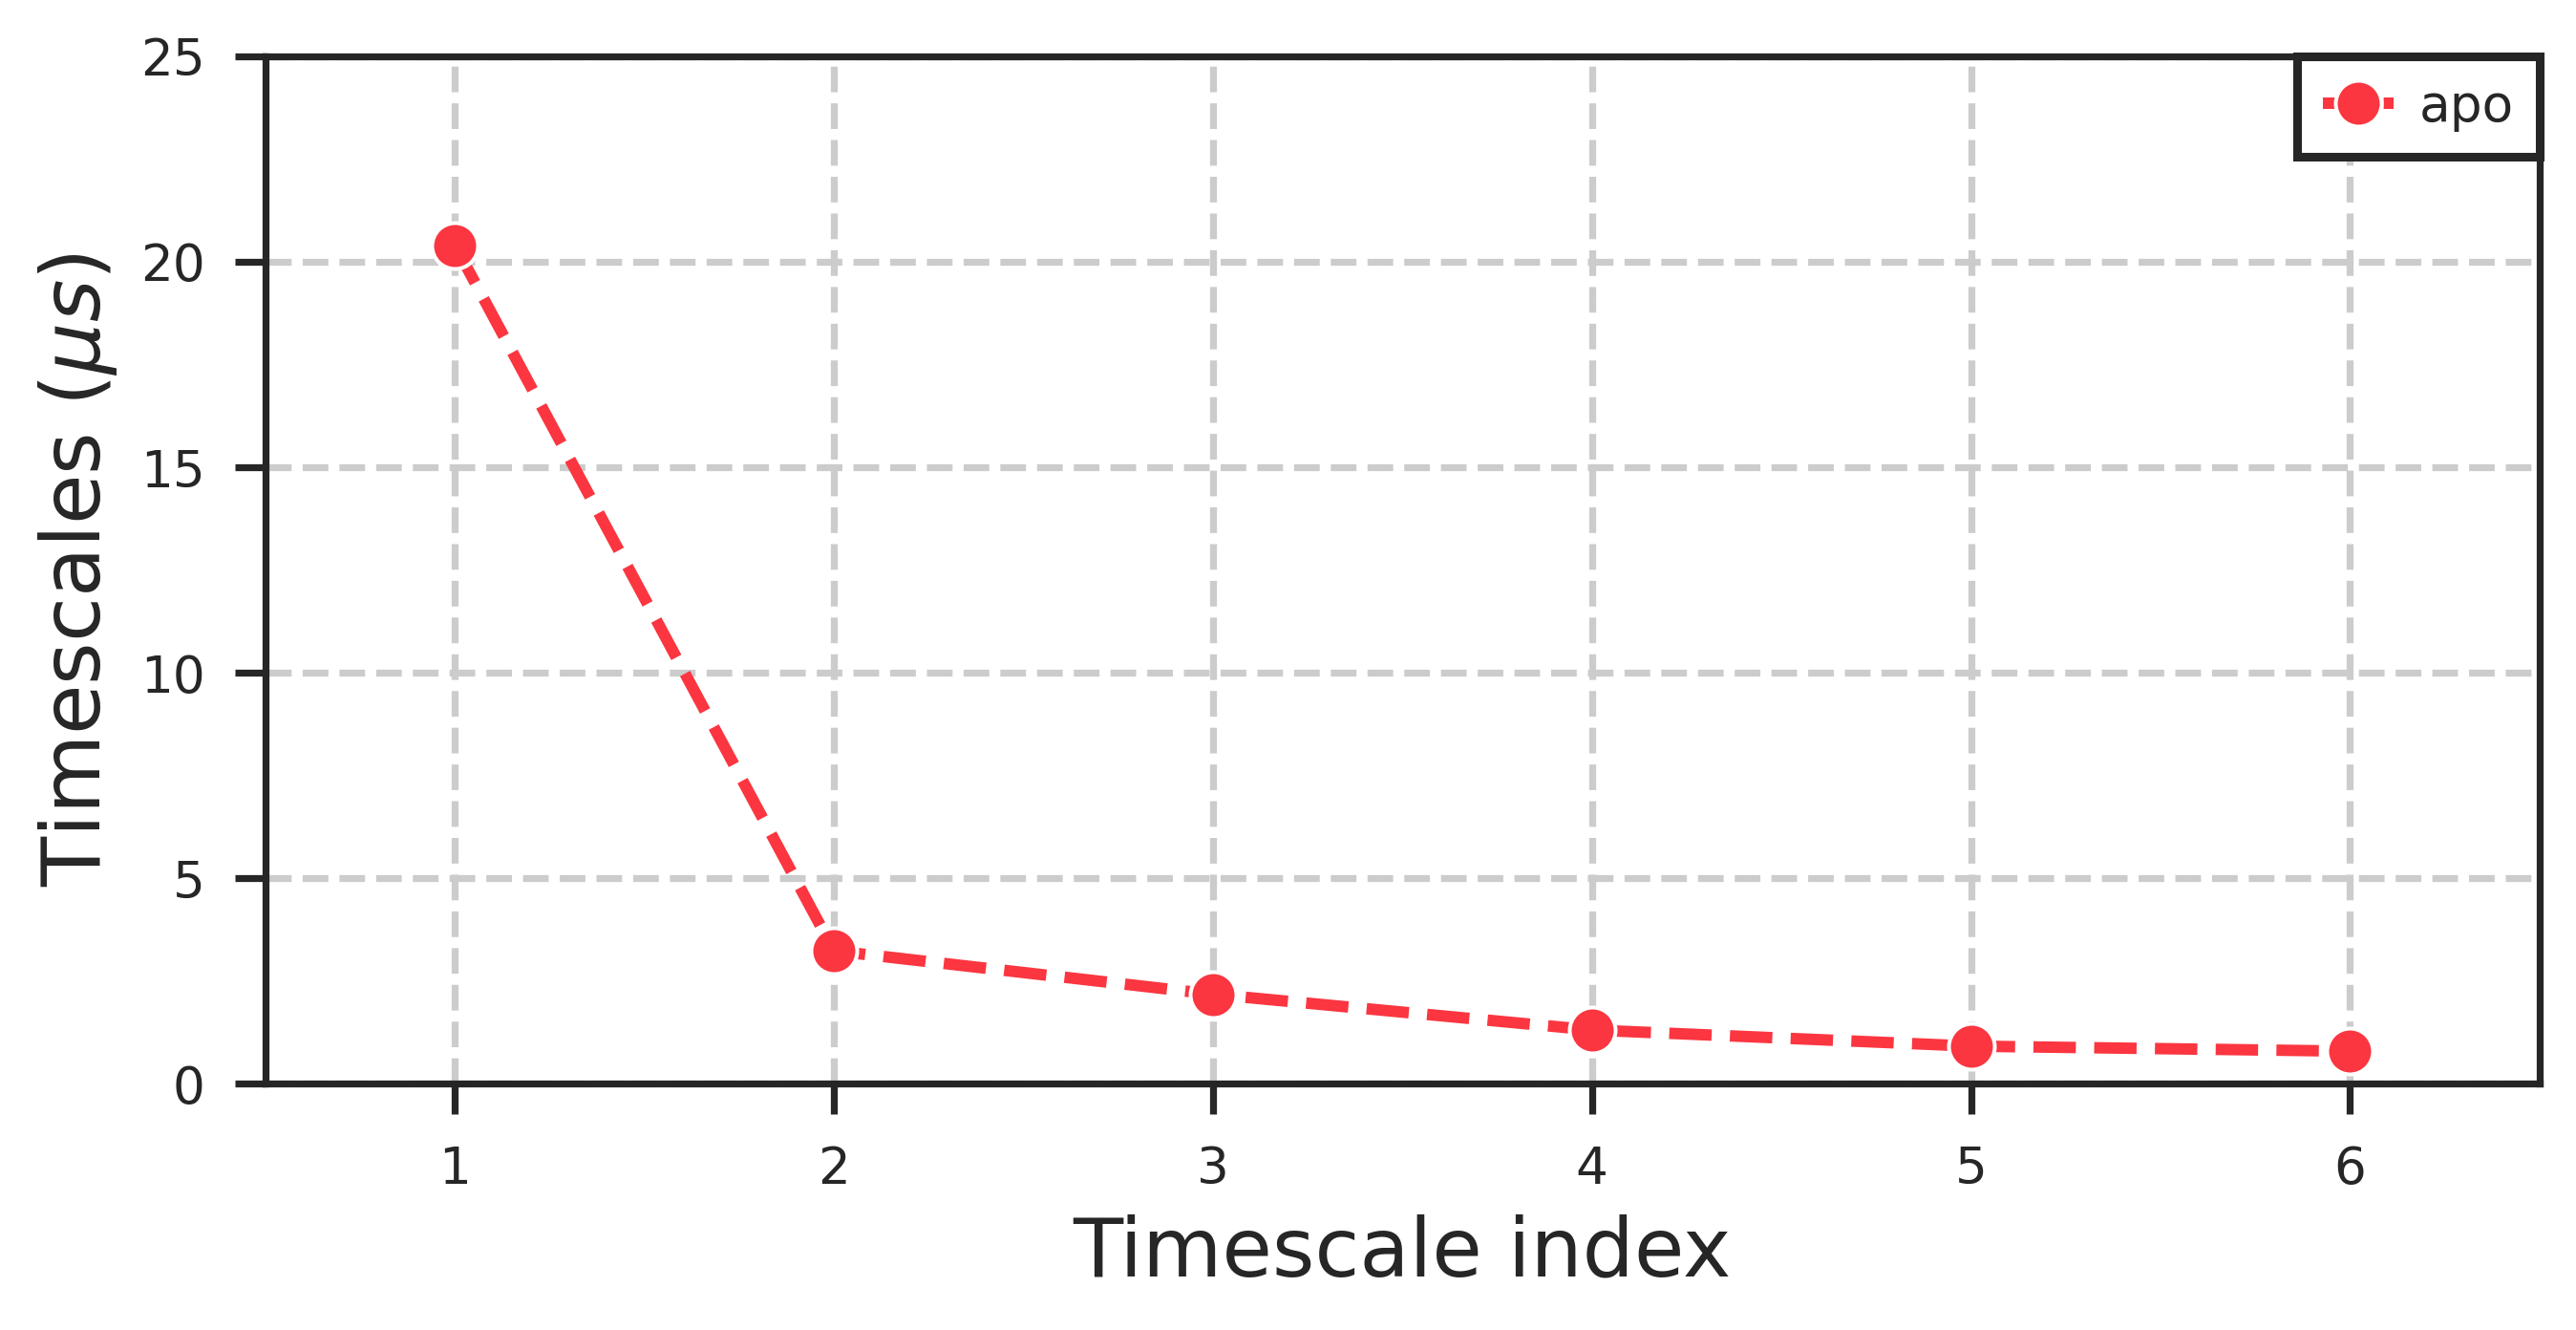

In [7]:
pplt.update_style(style='default', mode='print')

fig, ax = plt.subplots(figsize=(8,4))
n_timescales=6
tic_series = np.arange(1, n_timescales+1)
time_series = tica_model_tica.timescales(k=n_timescales) * msm_obj.dt / 1000
sns.lineplot(x=tic_series,
             y=time_series,
             marker='o', linestyle='--',
             color=system_color_dict['apo'], label='apo')
#for tic, time in zip(tic_series, time_series):
#    ax.text(x=tic + 0.1, y=time + 1.2, s='{:0.1f}'.format(time), fontsize=16)
ax.set_ylabel(r'Timescales ($\mu s$)', fontsize=16)
ax.set_xlabel('Timescale index', fontsize=16)
ax.set_ylim(0,25)
ax.set_xlim(0.5,n_timescales+0.5)
ax.set_xticks(tic_series)
plt.savefig('Figures/timescales_symtica_selfeat_apo.pdf', dpi=300, bbox_inches='tight',
            transparent=True)

Load other dataframe for projection

In [11]:
md_7ekt_dataframe = MDDataFrame.load_dataframe('./7ekt_feature/7ekt_feature_md_dataframe')
tica_output_7ekt = msm_obj.transform_feature_trajectories(md_7ekt_dataframe,
                                                          symmetrized=False)
tica_output_subunit_7ekt = msm_obj.transform_feature_trajectories(md_7ekt_dataframe,
                                                                  subunit=True,
                                                                  symmetrized=False)

Loading ./7ekt_feature/7ekt_feature_md_dataframe.pickle


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 31.41it/s]


## Step.3 MSM
Construct MSM with SymTICA coordinates

In [15]:
tica_dens_kwargs = {'logscale': True,
                    'cmap': 'inferno',
                    'ncontours': 30,
                    'nbins': 80
}

In [16]:
state_tica_coord = {}
for seed, struc in zip(start_seed_index[::2],
                       start_seed_strucs[::2]):
    state_tica_coord[struc_2_state[struc]] = {}
    state_tica_coord[struc_2_state[struc]]['tica']= tica_output[seed][0, :]
    state_tica_coord[struc_2_state[struc]]['tica_subunit'] = tica_subunit_output[seed][0, :, :]

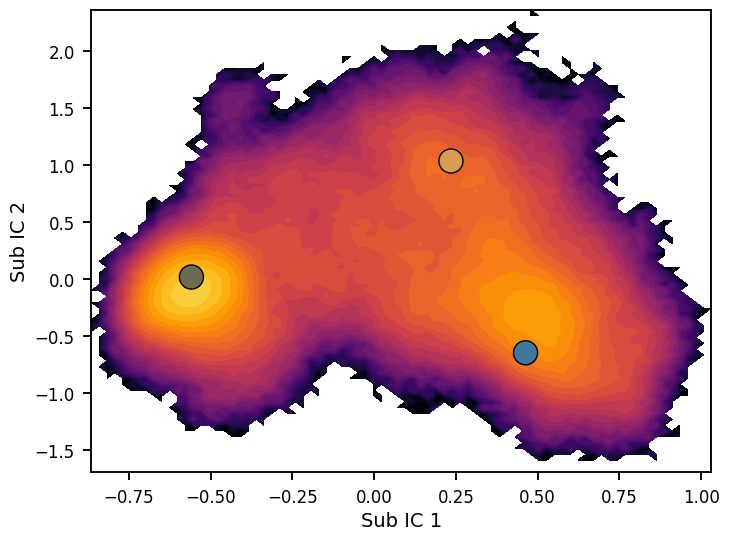

In [17]:
pplt.update_style(style='none', mode='print')
fig, ax = plt.subplots(figsize=(8,6))
tica_subunit_sep_concate = np.concatenate(tica_subunit_concatenated, axis=0)

contourf_kws = dict(locator=ticker.LogLocator(base=10, subs=range(1, 10)))
pyemma.plots.plot_density(
            tica_subunit_sep_concate.T[0],
            tica_subunit_sep_concate.T[1],
            **tica_dens_kwargs,
            cbar=False,
            ax=ax)

ax.scatter(x=np.mean([state_tica_coord[state]['tica_subunit'][:,0] for state in state_tica_coord], axis=1),
           y=np.mean([state_tica_coord[state]['tica_subunit'][:,1] for state in state_tica_coord], axis=1),
           marker='o', s=300,
           c=[state_color_dict[state] for state in state_tica_coord],
           edgecolors='black',
           lw=1)

ax.set_xlabel('Sub IC 1', fontsize=14)
ax.set_ylabel('Sub IC 2', fontsize=14)

plt.savefig('Figures/tica_subsystem_all_apo.pdf', dpi=300, bbox_inches='tight',
            transparent=True)

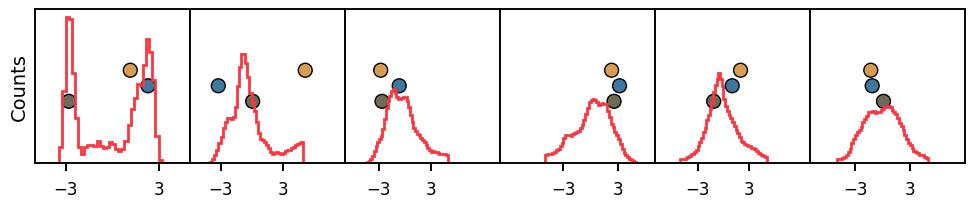

In [18]:
n_timescales=6
pplt.update_style(style='none', mode='print')

fig, axes = plt.subplots(1, n_timescales, figsize=(2 * n_timescales, 2),
                        sharey=True, gridspec_kw={'wspace': 0.0},
                        subplot_kw={'yticks': []}
                         )
for tic, ax in zip(range(n_timescales), axes):
    ax.hist(tica_concatenated[:, tic].T, bins=50,
            range=([-5, 5]),
            histtype='step',
            color=system_color_dict['apo'], lw=2,
            fill=False, density=True)
#    ax.set_xlabel('IC ' + str(tic+1))
    ax.set_yticklabels([])
    ax.set_xticks([-3, 3])
    ax.set_xlim(int(tica_concatenated[:, tic].T.min()) - 2, 
                int(tica_concatenated[:, tic].T.max()) + 2)
    ax.scatter([state_tica_coord[state]['tica'][tic] for state in state_tica_coord],
               [[0.2 + i * 0.05] for i, state in enumerate(state_tica_coord)],
                marker='o', s=100,
                c=[state_color_dict[state] for state in state_tica_coord],
                edgecolors='black', lw=1)
axes[0].set_ylabel('Counts', fontsize=14)
plt.savefig('Figures/symtica_hist_all_apo.pdf', dpi=300, bbox_inches='tight',
            transparent=True)

In [19]:
vis_tic = [0,1]

/tmp/ipykernel_107445/2299379013.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{i:.0f}' for i in ax.get_xticks()], fontsize=16)
/tmp/ipykernel_107445/2299379013.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{i:.0f}' for i in ax.get_yticks()], fontsize=16)


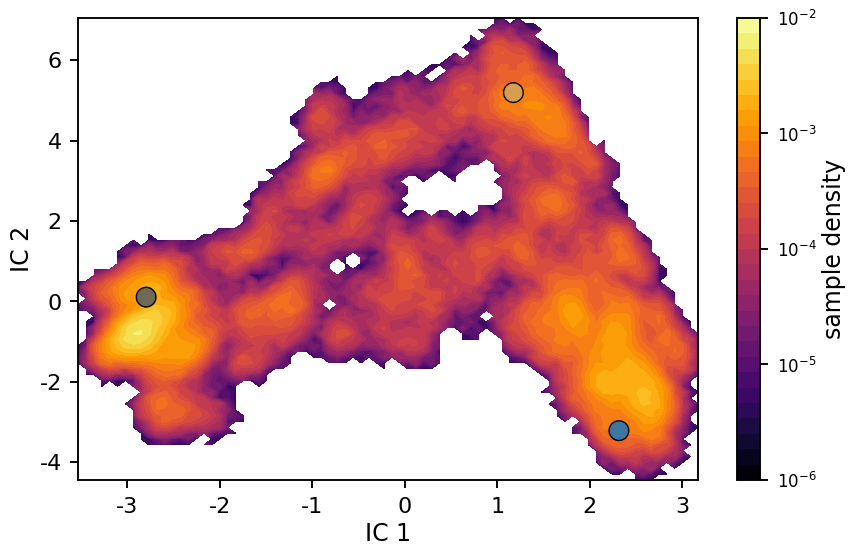

In [20]:
from matplotlib.ticker import LogLocator, MultipleLocator

fig, ax = plt.subplots(figsize=(10, 6))

_, _, misc = pyemma.plots.plot_density(*tica_concatenated[:, vis_tic].T,
                                       ax=ax,
                                       **tica_dens_kwargs
                                       )

ax.set_xlabel(f'IC {vis_tic[0]+1}', fontsize=17)
ax.set_ylabel(f'IC {vis_tic[1]+1}', fontsize=17)
ax.set_xticklabels([f'{i:.0f}' for i in ax.get_xticks()], fontsize=16)
ax.set_yticklabels([f'{i:.0f}' for i in ax.get_yticks()], fontsize=16)

ax.scatter(x=[state_tica_coord[state]['tica'][0] for state in state_tica_coord],
           y=[state_tica_coord[state]['tica'][1] for state in state_tica_coord],
           marker='o', s=200,
           c=[state_color_dict[state] for state in state_tica_coord],
           edgecolors='black', lw=1)

misc['cbar'].set_ticks(LogLocator(base=10.0, numticks=15))
misc['cbar'].ax.set_ylabel('sample density', fontsize=17)

plt.savefig('Figures/tica_whole_sys_all_apo.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1, transparent=True)

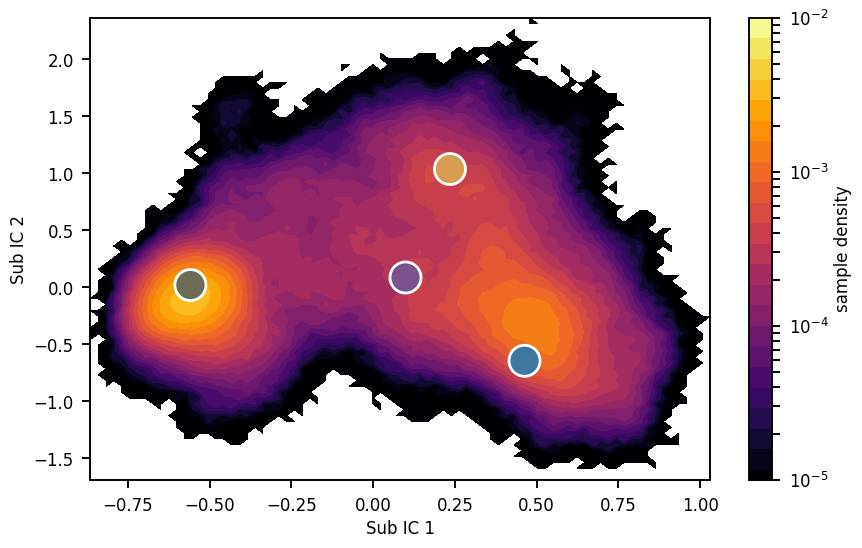

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
pplt.update_style(style='none', mode='print')

tica_subunit_sep_concate = np.concatenate(tica_subunit_concatenated, axis=0)

_, _ , misc = pyemma.plots.plot_density(
            tica_subunit_sep_concate.T[0],
            tica_subunit_sep_concate.T[1],
            vmin=1e-5,
            vmax=1e-2,
            **tica_dens_kwargs,
            ax=ax)

misc['cbar'].ax.set_ylim(1e-5,1e-2)

ax.scatter(x=np.mean([state_tica_coord[state]['tica_subunit'][:,0] for state in state_tica_coord], axis=1),
           y=np.mean([state_tica_coord[state]['tica_subunit'][:,1] for state in state_tica_coord], axis=1),
           marker='o', s=500,
           c=[state_color_dict[state] for state in state_tica_coord],
           edgecolors='white',
           lw=2)
           
concat_7ekt = np.concatenate(np.concatenate(tica_output_subunit_7ekt),
                             axis=0)
ax.scatter(concat_7ekt[0, 0], concat_7ekt[0, 1],
           s=500, c='#7C528C', edgecolors='white',lw=2
)
#ax.scatter(concat_7ekt[:, 0], concat_7ekt[:, 1],
#           s=5, cmap='Blues', c=range(len(concat_7ekt)))

ax.set_xlabel('Sub IC 1')
ax.set_ylabel('Sub IC 2')
plt.savefig('Figures/tica_7ekt_sub_all_apo.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1, transparent=True)

### Clustering and Microstates

In [24]:
meaningful_tic = [0, 1]

In [25]:
cross_validation = False
if cross_validation:
    tica_output_filter = [np.asarray(output)[:,meaningful_tic] for output in tica_output]
    n_clustercenters = [50, 200, 500, 1000, 2000, 4000]

    scores = np.zeros((len(n_clustercenters), 5))
    for n, k in enumerate(n_clustercenters):
        for m in range(5):
            d_cluster = pyemma.coordinates.cluster_kmeans(tica_output_filter,
                                                          k=k,
                                                          max_iter=100,
                                                          stride=100)
            d_cluster_dtrajs = d_cluster.dtrajs
            _msm = pyemma.msm.estimate_markov_model(d_cluster_dtrajs, 100)
            scores[n, m] = _msm.score_cv(
                d_cluster_dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))
#            print(scores[n, m])

if cross_validation:
    fig, ax = plt.subplots()
    lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
    ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
    ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
    ax.semilogx()
    ax.set_xlabel('number of cluster centers')
    ax.set_ylabel('VAMP-2 score')
    fig.tight_layout()

In [26]:
msm_obj.clustering_with_deeptime(
                    meaningful_tic=meaningful_tic,
                    n_clusters=1000,
                    updating=False,
                )

Meaningful TICs are [0, 1]
Loading old cluster analysis


/nethome/yzhuang/anaconda3/envs/msm_manuscript/lib/python3.10/site-packages/deeptime/base.py:116: UserWarning: Trying to unpickle estimator KMeansModel from version 0.4.4 when using version 0.4.4+6.ga6ac0b9. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [27]:
cluster = msm_obj.cluster
cluster_centers = msm_obj.cluster_centers
cluster_dtrajs = msm_obj.cluster_dtrajs
dtrajs_concatenated = msm_obj.dtrajs_concatenated

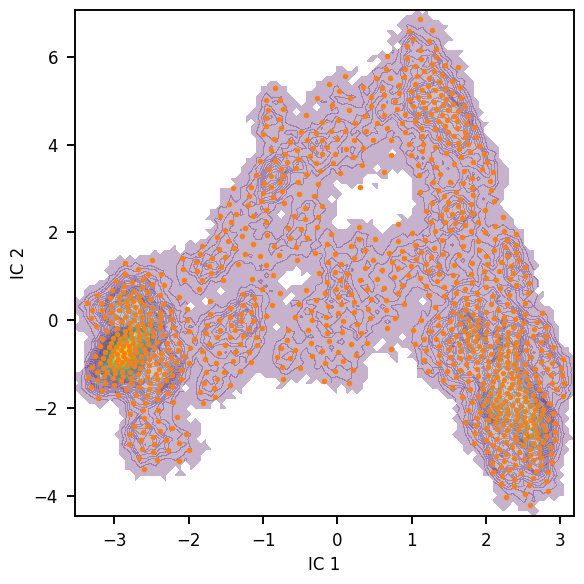

In [29]:
pplt.update_style(style='none', mode='print')

sel_tic = [0, 1]

fig, ax = plt.subplots(figsize=(6, 6))
pyemma.plots.plot_density(
    *tica_concatenated[:, sel_tic].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster_centers[:, [0, 1]].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()
plt.savefig('Figures/microstates_apo.pdf', bbox_inches = 'tight', pad_inches=0.0, transparent=True)

### ITS test

In [30]:
its = msm_obj.get_its(cluster='deeptime', n_samples=100, n_jobs=10,
                      lag_max=500)
#msm_obj.plot_its()

Loading old ITS analysis


/nethome/yzhuang/anaconda3/envs/msm_manuscript/lib/python3.10/site-packages/deeptime/base.py:116: UserWarning: Trying to unpickle estimator TransitionCountModel from version 0.4.4 when using version 0.4.4+6.ga6ac0b9. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/nethome/yzhuang/anaconda3/envs/msm_manuscript/lib/python3.10/site-packages/deeptime/base.py:116: UserWarning: Trying to unpickle estimator MarkovStateModelCollection from version 0.4.4 when using version 0.4.4+6.ga6ac0b9. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/nethome/yzhuang/anaconda3/envs/msm_manuscript/lib/python3.10/site-packages/deeptime/base.py:116: UserWarning: Trying to unpickle estimator MarkovStateModel from version 0.4.4 when using version 0.4.4+6.ga6ac0b9. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/nethome/yzhuang/anaconda3/envs/msm_manuscript/lib/python3.10/site-pack

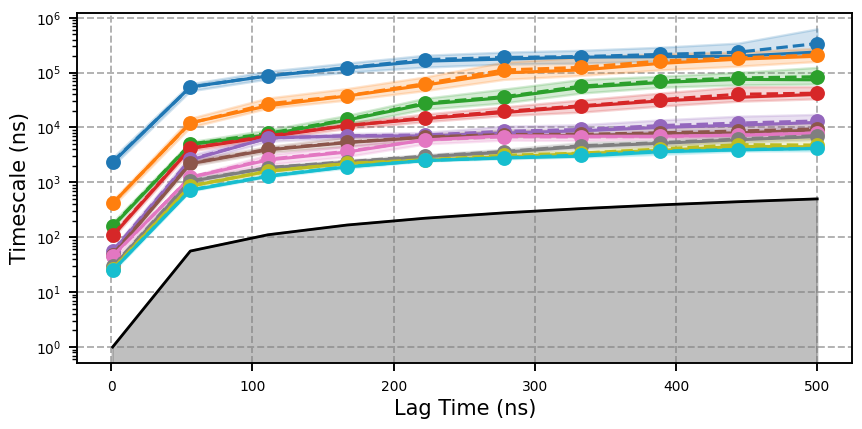

In [31]:
from deeptime.plots import plot_implied_timescales, plot_ck_test
pplt.update_style(style='default', mode='print')
fig, ax = plt.subplots(figsize=(10, 5))
plot_implied_timescales(msm_obj.its, n_its=10, ax=ax)
ax.set_yscale("log")
#ax.set_title("Implied timescales")

ax.set_xlabel(f"Lag Time (ns)", fontsize=15)
ax.set_ylabel(f"Timescale (ns)", fontsize=15)

plt.savefig('Figures/its_apo.pdf', bbox_inches = 'tight', pad_inches=0.0, transparent=True)

### MSM

In [33]:
msm_model = msm_obj.get_bayesian_msm(lag=100, cluster='deeptime')

msm_obj.get_connected_msm()

print('fraction of states used = {:.4f}'.format(msm_model.prior.state_fraction))
print('fraction of states used = {:.4f}'.format(msm_model.prior.count_fraction))

Loading old MSM analysis


/nethome/yzhuang/anaconda3/envs/msm_manuscript/lib/python3.10/site-packages/deeptime/base.py:116: UserWarning: Trying to unpickle estimator TransitionCountModel from version 0.4.4 when using version 0.4.4+6.ga6ac0b9. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/nethome/yzhuang/anaconda3/envs/msm_manuscript/lib/python3.10/site-packages/deeptime/base.py:116: UserWarning: Trying to unpickle estimator MarkovStateModelCollection from version 0.4.4 when using version 0.4.4+6.ga6ac0b9. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/nethome/yzhuang/anaconda3/envs/msm_manuscript/lib/python3.10/site-packages/deeptime/base.py:116: UserWarning: Trying to unpickle estimator MarkovStateModel from version 0.4.4 when using version 0.4.4+6.ga6ac0b9. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/nethome/yzhuang/anaconda3/envs/msm_manuscript/lib/python3.10/site-pack

fraction of states used = 1.0000
fraction of states used = 1.0000


In [34]:
active_set = msm_obj.active_set
inactive_set = msm_obj.inactive_set
stat_rank_mapping = msm_obj.stat_rank_mapping

connected_indices = msm_obj.connected_indices
cluster_rank_connected_concat = msm_obj.cluster_rank_connected_concat
stat_rank_mapping_connected = msm_obj.stat_rank_mapping_connected

In [35]:
# Plot if there are unconnected states
if msm_model.prior.state_fraction != 1.0:
    active_set = msm_model.prior.count_model.states_to_symbols(msm_model.prior.count_model.states)
    inactive_set = list(set(range(msm_model.prior.count_model.n_states_full)).difference(set(active_set)))
    print('Unconnected states:', inactive_set)

    fig, ax = plt.subplots(figsize=(6, 6))

    pyemma.plots.plot_density(
        *tica_concatenated[:, meaningful_tic[:2]].T, ax=ax, cbar=False, alpha=0.3)
    ax.scatter(*cluster_centers[active_set, :2].T, s=5, c='C1')
    ax.scatter(*cluster_centers[inactive_set, :2].T, s=50, c='black')
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
    fig.tight_layout()

### Plotting

In [41]:
# Get webpage with FES and samples of each trajectory
generate_tica_csv(msm_obj.md_dataframe, msm_obj, output='data/apo_tica.csv')

fig = export_plotly(tica_csv='data/apo_tica.csv',
                    output='html/apo_msm.html',
                    title='FES APO')

100%|██████████| 195/195 [01:45<00:00,  1.86it/s]


tica_csv:  data/apo_tica.csv
output:  html/apo_msm.html
sel_tic:  [0, 1]
Exported html/apo_msm.html


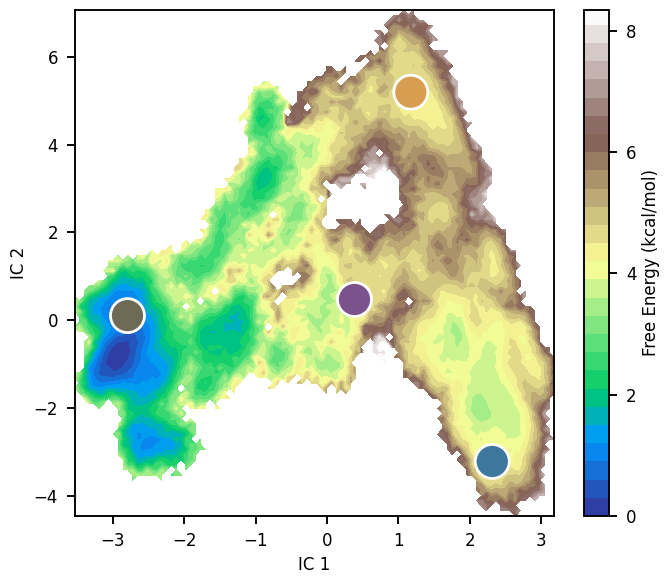

In [42]:
pplt.update_style(style='none', mode='print')
struc_state_dic = {
        'BGT': 'CLOSED',
        'EPJ': 'DESENSITIZED',
        '7ekt': 'I (7EKT)',
        'EPJPNU': 'OPEN',
}
kT = 0.596
fig, ax = plt.subplots(figsize=(7, 6), sharex=True, sharey=True)

fe_plot = pyemma.plots.plot_free_energy(
    *tica_concatenated[:, meaningful_tic[:2]].T,
    weights=np.concatenate(msm_obj.trajectory_weights),
    ncontours=30,
    ax=ax, cmap='terrain', vmax=14 * kT,
    kT=kT,
    legacy=False,
    cbar_label='Free Energy (kcal/mol)')

ymax = 14 * kT
fe_plot[2]['cbar'].ax.set_ylim(0,ymax)
fe_plot[2]['cbar'].ax.set_yticks(np.arange(0,ymax,2))

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')


ax.scatter(tica_output_7ekt[0][0, vis_tic[0]],
           tica_output_7ekt[0][0, vis_tic[1]],
           color='#7C528C', s=600, edgecolors='white', lw=2)


ax.scatter(x=[state_tica_coord[state]['tica'][0] for state in state_tica_coord],
           y=[state_tica_coord[state]['tica'][1] for state in state_tica_coord],
           marker='o', s=600,
           c=[state_color_dict[state] for state in state_tica_coord],
           edgecolors='white', lw=2)

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')

#ax.set_title('Free Energy Surface', fontweight='bold')
fig.tight_layout()
plt.savefig('Figures/a7_apo_fes.pdf',bbox_inches = 'tight', pad_inches=0.0, transparent=True)

### CK test

Loading old CK test


/nethome/yzhuang/anaconda3/envs/msm_manuscript/lib/python3.10/site-packages/deeptime/base.py:116: UserWarning:

Trying to unpickle estimator TransitionCountModel from version 0.4.4 when using version 0.4.4+6.ga6ac0b9. This might lead to breaking code or invalid results. Use at your own risk.

/nethome/yzhuang/anaconda3/envs/msm_manuscript/lib/python3.10/site-packages/deeptime/base.py:116: UserWarning:

Trying to unpickle estimator MarkovStateModelCollection from version 0.4.4 when using version 0.4.4+6.ga6ac0b9. This might lead to breaking code or invalid results. Use at your own risk.

/nethome/yzhuang/anaconda3/envs/msm_manuscript/lib/python3.10/site-packages/deeptime/base.py:116: UserWarning:

Trying to unpickle estimator MarkovStateModel from version 0.4.4 when using version 0.4.4+6.ga6ac0b9. This might lead to breaking code or invalid results. Use at your own risk.

/nethome/yzhuang/anaconda3/envs/msm_manuscript/lib/python3.10/site-packages/deeptime/base.py:116: UserWarning:

Tryi

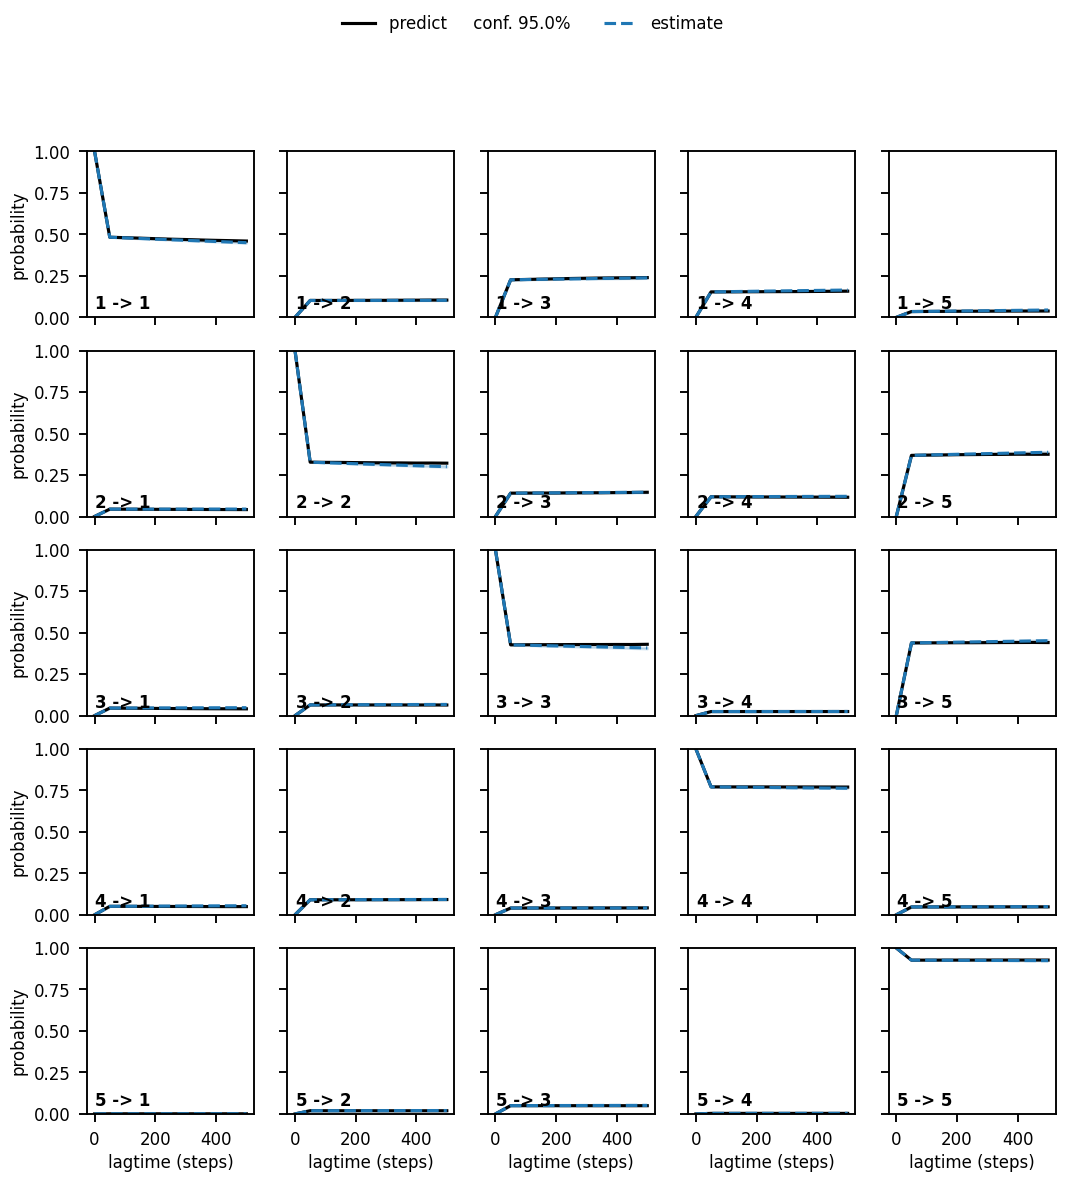

In [44]:
n_states = 5
ck_grid = msm_obj.get_ck_test(n_states=n_states,
                              lag=50,
                              mlags=10,
                              n_jobs=10)

In [45]:
for ax in ck_grid.axes[-1]:
    ax.set_xlabel('Lag Time (ns)')

fig = ck_grid.figure

fig.savefig('Figures/ck_test_5_state_apo.pdf',bbox_inches = 'tight', pad_inches=0.0, transparent=True)

## Step.4 PCCA

In [46]:
n_states = 5

In [47]:
msm_obj.pcca = msm_model.prior.pcca(n_states)

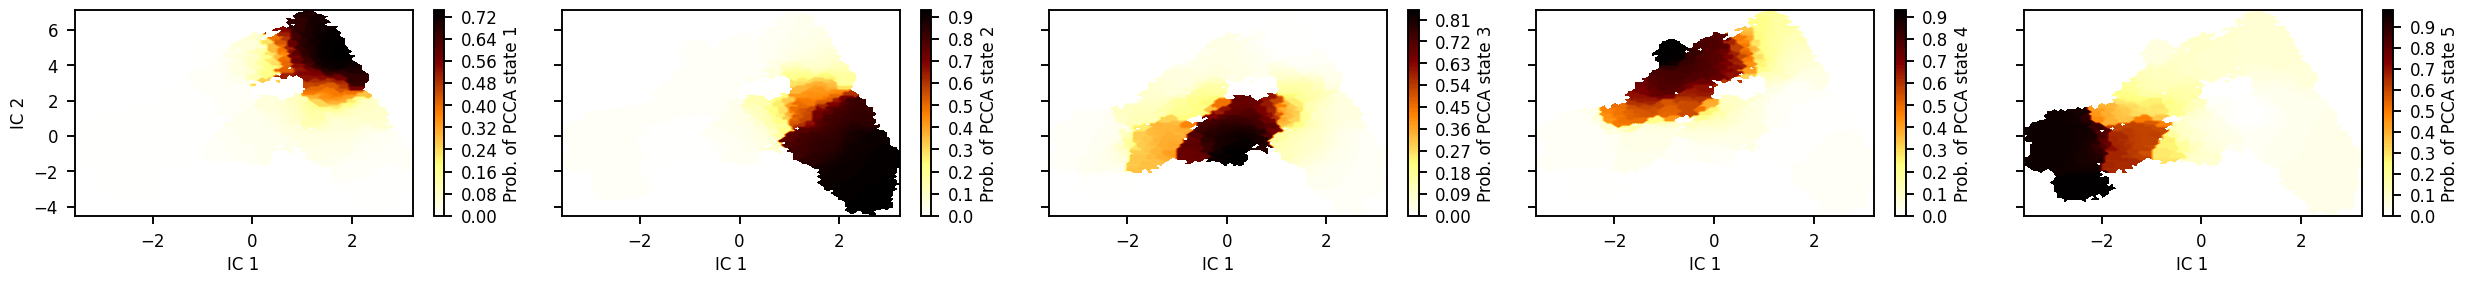

In [48]:
pplt.update_style(style='none', mode='print')
fig, axes = plt.subplots(1, n_states, figsize=(5*n_states, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, meaningful_tic[:2]].T,
        msm_obj.pcca.memberships.T[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r', 
        mask=True,
        cbar_label='Prob. of PCCA state {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

In [49]:
metastable_traj = [msm_obj.pcca.assignments[c_traj] for c_traj in cluster_dtrajs]
metastable_concat = np.concatenate(metastable_traj)

In [50]:
state_by_energy = ['desensitized',
                    'open',
                    'flipped',
                    'intermediate',
                    'closed']
state_labels= dict(zip(range(n_states), state_by_energy))

In [51]:
state_order = ['closed', 'flipped', 'open', 'desensitized', 'intermediate']

In [52]:
print('label\tstate\tπ\t\tG/kT')
stationary_distribution = {}
for i, s in enumerate(msm_obj.pcca.sets):
    p = msm_obj.stationary_distribution[s].sum()
    print('{}\t{}\t{:f}\t{:f}'.format(state_labels[i], i + 1, p, -np.log(p)))
    stationary_distribution[state_labels[i]] = p

print('')
# print out Latex table
fe_table = pd.DataFrame(columns=['state', 'G (kcal/mol)'])

for i, s in enumerate(msm_obj.pcca.sets):
    p = msm_obj.stationary_distribution[s].sum()
    fe_table.loc[i] = [state_labels[i], -np.log(p) * 0.596]

# reorder table by state_order
fe_table['name'] = fe_table['state'].map(state_order.index)
fe_table = fe_table.sort_values(by='name')
fe_table = fe_table.drop('name', axis=1)
print(fe_table.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.1f}".format,
))

label	state	π		G/kT
desensitized	1	0.001434	6.547516
open	2	0.009125	4.696704
flipped	3	0.008078	4.818610
intermediate	4	0.044868	3.104036
closed	5	0.936495	0.065611

\begin{tabular}{lr}
\toprule
state & G (kcal/mol) \\
\midrule
closed & 0.0 \\
flipped & 2.9 \\
open & 2.8 \\
desensitized & 3.9 \\
intermediate & 1.9 \\
\bottomrule
\end{tabular}



In [72]:
from itertools import product

mfpt = np.zeros((n_states, n_states))
mfpt_std = np.zeros((n_states, n_states))

for i, j in tqdm(product(range(n_states), repeat=2),
                  total=n_states**2,
                  desc='Computing MFPTs'):
    stats_mfpt = msm_model.gather_stats("mfpt",
                                        A=msm_obj.pcca.sets[i],
                                        B=msm_obj.pcca.sets[j])
    mfpt[i, j] = stats_mfpt.mean * msm_obj.dt

    mfpt_std[i, j] = stats_mfpt.std * msm_obj.dt

Computing MFPTs: 100%|██████████| 25/25 [01:44<00:00,  4.17s/it]


In [73]:
print('MFPT / us:')
DataFrame(np.round(mfpt / 1000, decimals=0),
            index=[state_labels[i] + ' to'
                             for i in range(n_states)],
            columns=[state_labels[i]
                             for i in range(n_states)])

MFPT / us:


,desensitized,open,flipped,intermediate,closed
desensitized to,0.0,3230.0,342.0,43.0,43.0
open to,1850.0,0.0,133.0,186.0,92.0
flipped to,3994.0,5226.0,0.0,195.0,14.0
intermediate to,3919.0,5652.0,463.0,0.0,14.0
closed to,4343.0,5925.0,593.0,307.0,0.0


In [74]:
print('MFPT STD / us:')

DataFrame(np.round(mfpt_std / 1000, decimals=2),
            index=[state_labels[i] + ' to'
                             for i in range(n_states)],
            columns=[state_labels[i]
                             for i in range(n_states)])

MFPT STD / us:


,desensitized,open,flipped,intermediate,closed
desensitized to,0.00,727.31,69.53,6.40,3.23
open to,430.66,0.00,19.40,21.55,7.30
flipped to,853.60,1110.76,0.00,33.11,1.77
intermediate to,851.33,1172.36,98.01,0.00,1.62
closed to,892.68,1197.43,116.22,43.01,0.00


In [75]:
inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

In [53]:
coarse_state_centers = []
for state in range(n_states):
    state_traj = metastable_concat == state
    tic_1 = np.mean(tica_concatenated[state_traj, 0])
    tic_2 = np.mean(tica_concatenated[state_traj, 1])
    coarse_state_centers.append(np.asarray([tic_1, tic_2]))

coarse_state_centers = np.asarray(coarse_state_centers)

In [54]:
meta_state_color_dict = {
    'open': '#3F5C7666',
    'closed': '#65685566',
    'desensitized': '#C78E5266',
    'flipped': '#7C528C66',
    'intermediate': '#4DB6AC66'
    }
label_2_symbol_dict = {'closed': 'C',
                       'flipped': 'F',
                       'open': 'O',
                       'desensitized': 'D',
                       'intermediate': 'I'}
state_order = ['closed', 'flipped', 'open', 'desensitized', 'intermediate']

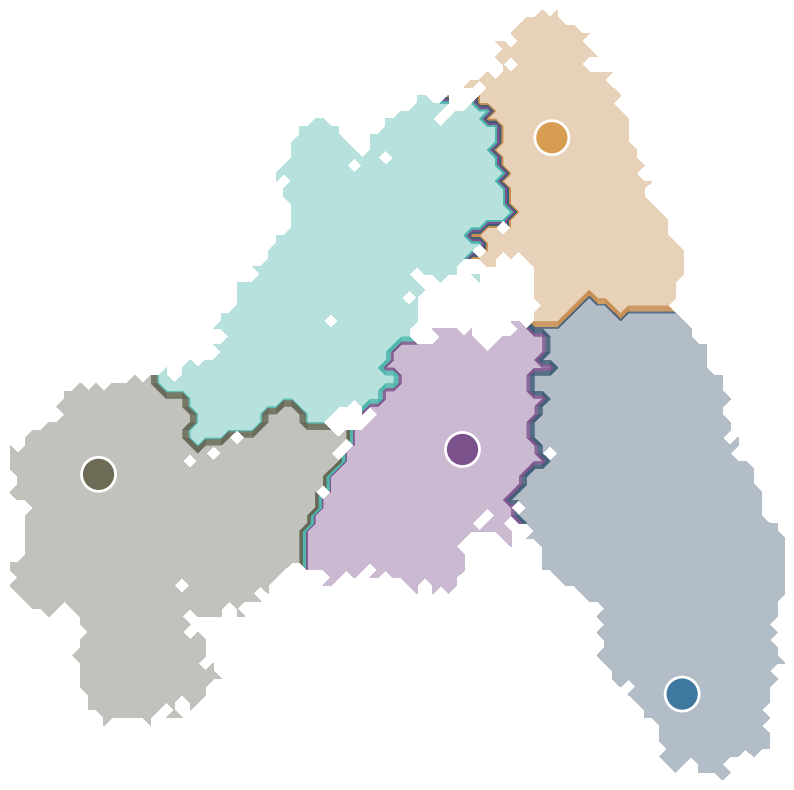

In [55]:
fig, ax = plt.subplots(figsize=(10, 10))
pplt.use_style(style='minimal', figsize=1.2, latex=False)

state_colors = [meta_state_color_dict[state_labels[i]] for i in range(n_states)]
state_cmap = matplotlib.colors.ListedColormap(state_colors, name='state')
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, meaningful_tic[:2]].T,
    metastable_concat,
    cbar=False,
    ax=ax, zorder=-1, cmap=state_cmap)

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')

ax.scatter(tica_output_7ekt[0][0, vis_tic[0]],
           tica_output_7ekt[0][0, vis_tic[1]],
           color='#7C528C', s=600, edgecolors='white', lw=2)


ax.scatter(x=[state_tica_coord[state]['tica'][0] for state in state_tica_coord],
           y=[state_tica_coord[state]['tica'][1] for state in state_tica_coord],
           marker='o', s=600,
           c=[state_color_dict[state] for state in state_tica_coord],
           edgecolors='white', lw=2)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_ylabel('')
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_xlabel('')
for spline in ax.spines.values():
    spline.set_visible(False)
plt.savefig('Figures/state_assignment_apo.pdf',bbox_inches = 'tight', pad_inches=0.0, transparent=True)

In [56]:
state_sizes = np.asarray([stationary_distribution[state_labels[i]] for i in range(n_states)])

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))

state_colors = [meta_state_color_dict[state_labels[i]] for i in range(n_states)]
state_sizes = np.asarray([stationary_distribution[state_labels[i]] for i in range(n_states)])
state_cmap = matplotlib.colors.ListedColormap(state_colors, name='state')
if False:
    _, _, misc = pyemma.plots.plot_state_map(
        *tica_concatenated[:, meaningful_tic[:2]].T,
        metastable_concat,
        cbar=False,
        ax=ax, zorder=-1, cmap=state_cmap)

inverse_mfpt_direct = inverse_mfpt.copy()

inverse_mfpt_direct[0,2] = 0
inverse_mfpt_direct[0,4] = 0
inverse_mfpt_direct[1,3] = 0
inverse_mfpt_direct[1,4] = 0
inverse_mfpt_direct[2,0] = 0
inverse_mfpt_direct[2,3] = 0
inverse_mfpt_direct[3,1] = 0
inverse_mfpt_direct[3,2] = 0
inverse_mfpt_direct[4,0] = 0
inverse_mfpt_direct[4,1] = 0

pyemma.plots.plot_network(
    inverse_mfpt_direct,
    pos=coarse_state_centers,
    figpadding=0,
    state_colors=state_colors,
    state_scale=10,
    state_sizes=state_sizes,
    arrow_label_format='%.0f µs',
    arrow_labels= mfpt / 1000,
    arrow_curvature=2,
    arrow_scale=2,
    size=20,
    show_frame=False,
    state_labels=[label_2_symbol_dict[state_labels[i]] for i in range(n_states)],
    ax=ax,
    )
ax.set_xlim(-6,6)
ax.set_ylim(-5,7)
fig.tight_layout()
plt.savefig('Figures/state_mfpt_apo.pdf',bbox_inches = 'tight', pad_inches=0.0, transparent=True)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))

state_colors = [meta_state_color_dict[state_labels[i]] for i in range(n_states)]
state_sizes = np.asarray([stationary_distribution[state_labels[i]] for i in range(n_states)])
state_cmap = matplotlib.colors.ListedColormap(state_colors, name='state')
if False:
    _, _, misc = pyemma.plots.plot_state_map(
        *tica_concatenated[:, meaningful_tic[:2]].T,
        metastable_concat,
        cbar=False,
        ax=ax, zorder=-1, cmap=state_cmap)

inverse_mfpt_direct = inverse_mfpt.copy()

inverse_mfpt_direct[0,2] = 0
inverse_mfpt_direct[0,4] = 0
inverse_mfpt_direct[1,3] = 0
inverse_mfpt_direct[1,4] = 0
inverse_mfpt_direct[2,0] = 0
inverse_mfpt_direct[2,3] = 0
inverse_mfpt_direct[3,1] = 0
inverse_mfpt_direct[3,2] = 0
inverse_mfpt_direct[4,0] = 0
inverse_mfpt_direct[4,1] = 0

pyemma.plots.plot_network(
    inverse_mfpt_direct,
    pos=coarse_state_centers,
    figpadding=0,
    state_colors=state_colors,
    state_scale=10,
    state_sizes=state_sizes,
    arrow_label_format=r'$\pm$%.0f µs',
    arrow_labels= mfpt_std / 1000,
    arrow_curvature=2,
    arrow_scale=2,
    size=18,
    show_frame=False,
    state_labels=[label_2_symbol_dict[state_labels[i]] for i in range(n_states)],
    ax=ax,
    )
ax.set_xlim(-6,6)
ax.set_ylim(-5,7)
fig.tight_layout()
plt.savefig('Figures/state_mfpt_std_apo.pdf',bbox_inches = 'tight', pad_inches=0.0, transparent=True)

### pyemma MFPT analysis

In [60]:
pyemma_msm = pyemma.msm.estimate_markov_model(msm_obj.cluster_dtrajs, lag=100)

In [61]:
bayesian_msm = pyemma.msm.bayesian_markov_model(msm_obj.cluster_dtrajs, lag=100, conf=0.95)

pyemma.msm.estimators.bayesian_msm.BayesianMSM[1]: Sampling MSMs:   0%|          | 0/100 [00:00<?, ?it/s]

In [62]:
print('fraction of states used = {:f}'.format(pyemma_msm.active_state_fraction))
print('fraction of counts used = {:f}'.format(pyemma_msm.active_count_fraction))

fraction of states used = 1.000000
fraction of counts used = 1.000000


In [ ]:
_ = pyemma_msm.pcca(n_states)

In [64]:
pyemma_metastable_traj = pyemma_msm.metastable_assignments[msm_obj.dtrajs_concatenated]
pyemma_highest_membership = pyemma_msm.metastable_distributions.argmax(1)
pyemma_coarse_state_centers = msm_obj.cluster_centers[pyemma_msm.active_set[pyemma_highest_membership]]

In [65]:
for i, s in enumerate(pyemma_msm.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, pyemma_msm.pi[s].sum()))
    print('G_{} = {:f}'.format(i + 1, -np.log(pyemma_msm.pi[s].sum())))

π_1 = 0.002205
G_1 = 6.116925
π_2 = 0.012044
G_2 = 4.419212
π_3 = 0.009604
G_3 = 4.645530
π_4 = 0.051508
G_4 = 2.966023
π_5 = 0.924639
G_5 = 0.078352


In [66]:
mfpt = np.zeros((n_states, n_states))
for i in range(n_states):
    for j in range(n_states):
        mfpt[i, j] = pyemma_msm.mfpt(
            pyemma_msm.metastable_sets[i],
            pyemma_msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / us:')
DataFrame(np.round(mfpt / 1000, decimals=0), index=range(1, n_states + 1), columns=range(1, n_states + 1))

MFPT / us:


,1,2,3,4,5
1,0.0,2412.0,280.0,49.0,41.0
2,964.0,0.0,118.0,176.0,89.0
3,2320.0,3779.0,0.0,175.0,14.0
4,2229.0,4133.0,380.0,0.0,12.0
5,2596.0,4364.0,496.0,281.0,0.0


In [67]:
mfpt_sample = np.zeros((n_states, n_states, bayesian_msm.nsamples))
for i in range(n_states):
    for j in range(n_states):
        mfpt_sample[i, j] = bayesian_msm.sample_f(
            'mfpt',
            pyemma_msm.metastable_sets[i],
            pyemma_msm.metastable_sets[j])

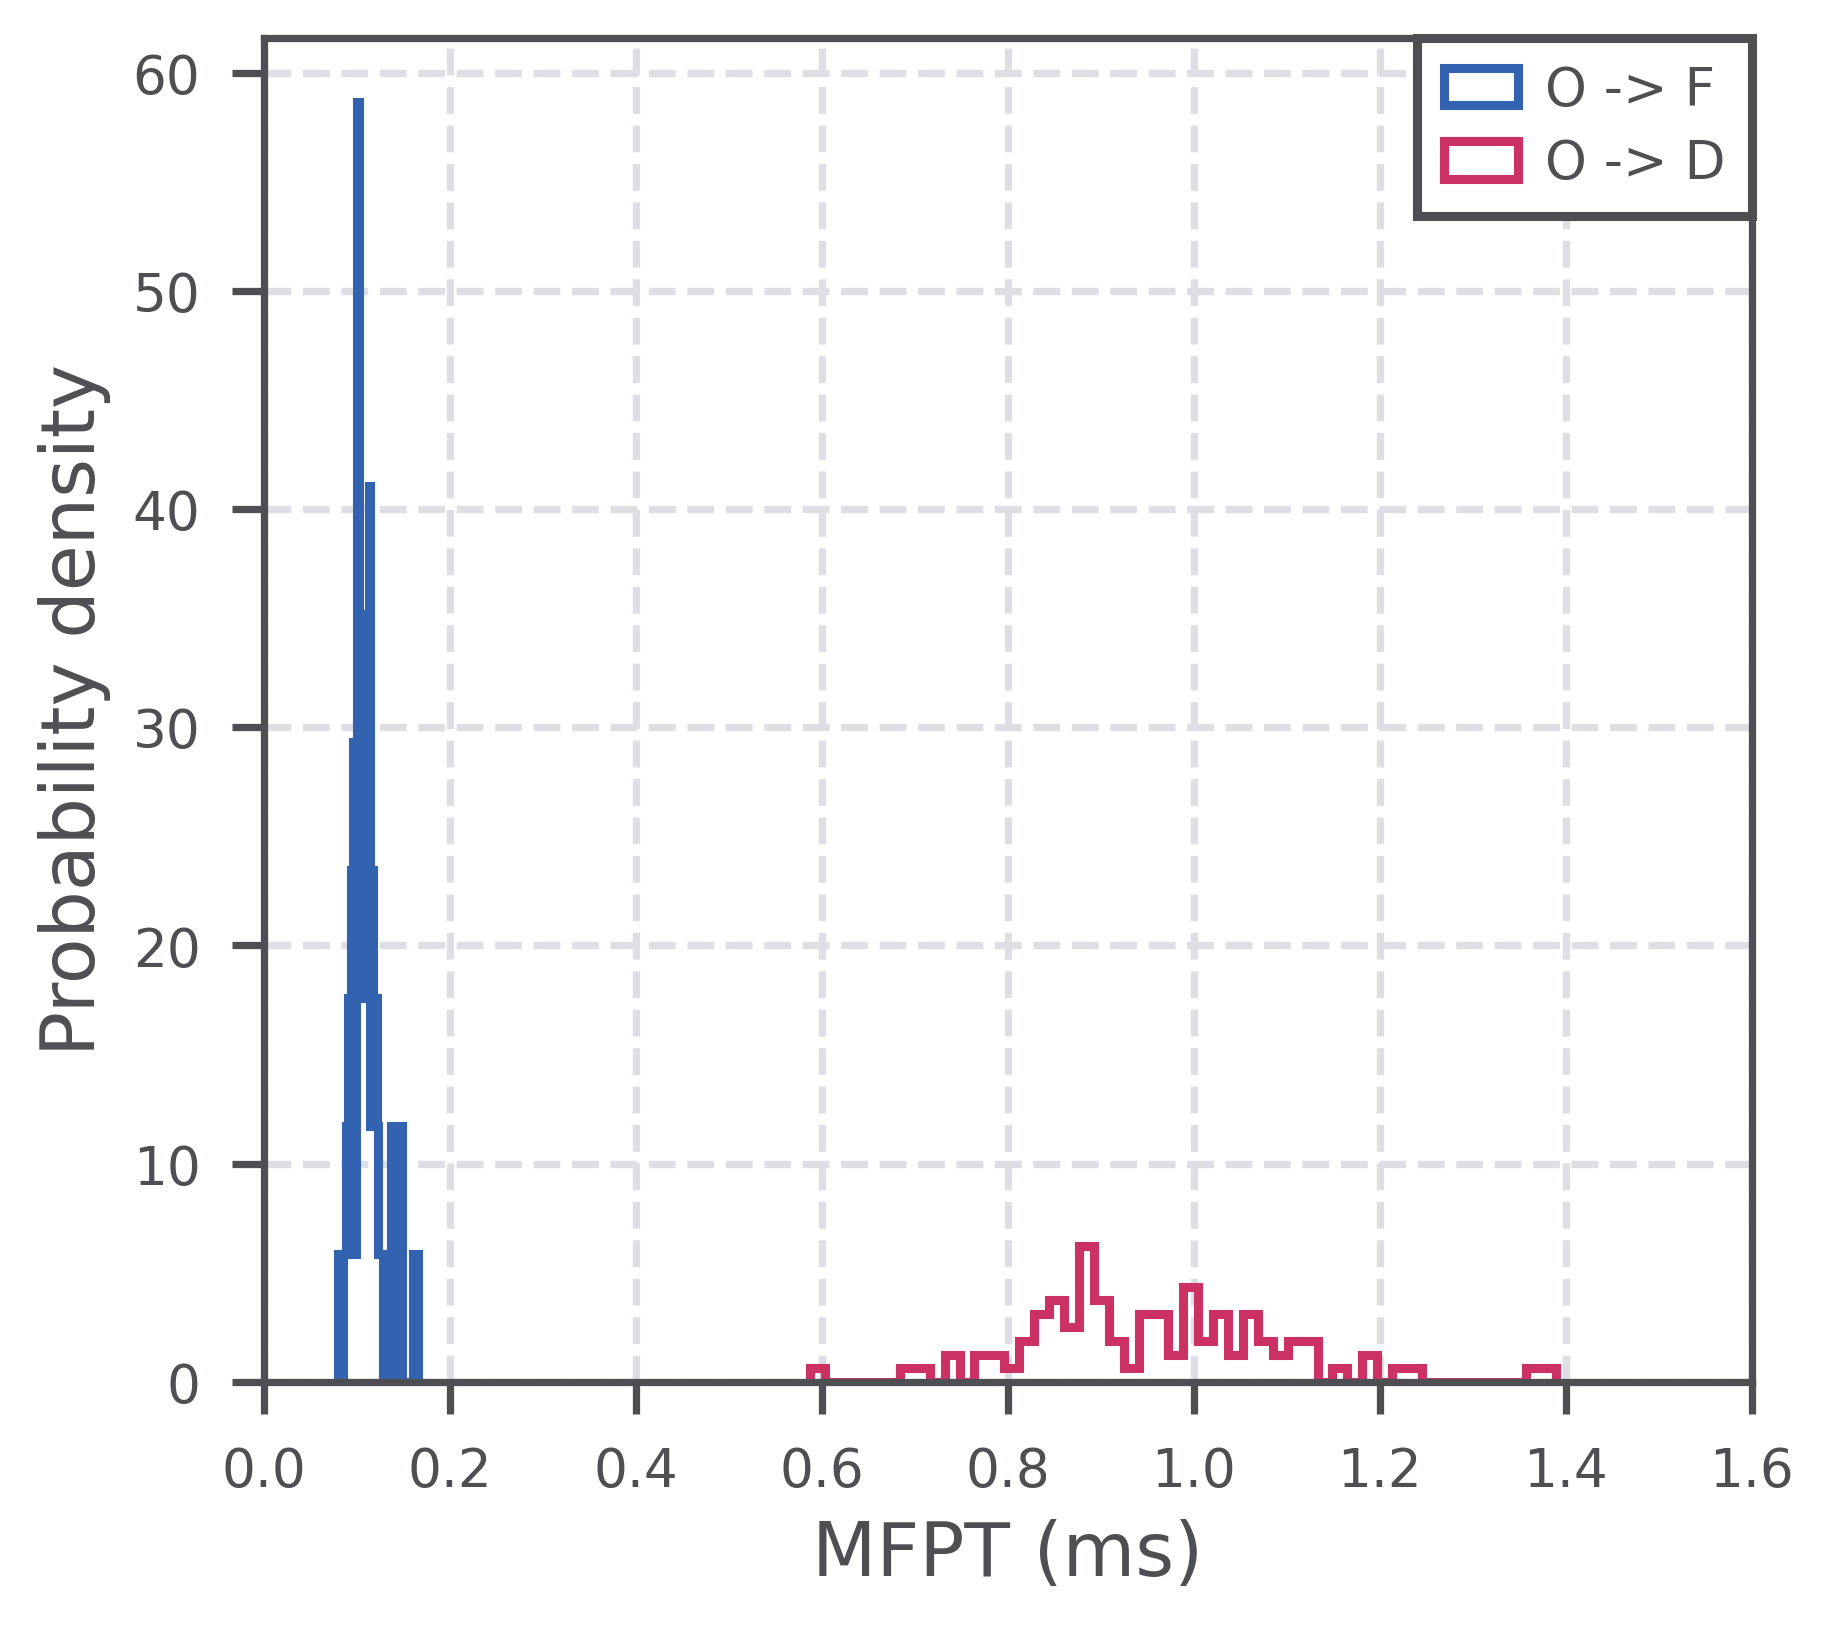

In [69]:
pplt.update_style(style='default', mode='print')
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(mfpt_sample[1, 2] / 1e6, histtype='step', label='O -> F', density=True)
ax.hist(mfpt_sample[1, 0] / 1e6, histtype='step', label='O -> D', density=True)
ax.set_xlabel('MFPT (ms)', fontsize=14)
plt.legend()
ax.set_xlim(0,1.6)
ax.set_ylabel('Probability density', fontsize=14)
plt.savefig('Figures/mfpt_sampled_apo.pdf',bbox_inches = 'tight', pad_inches=0.0, transparent=True)

In [71]:
inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

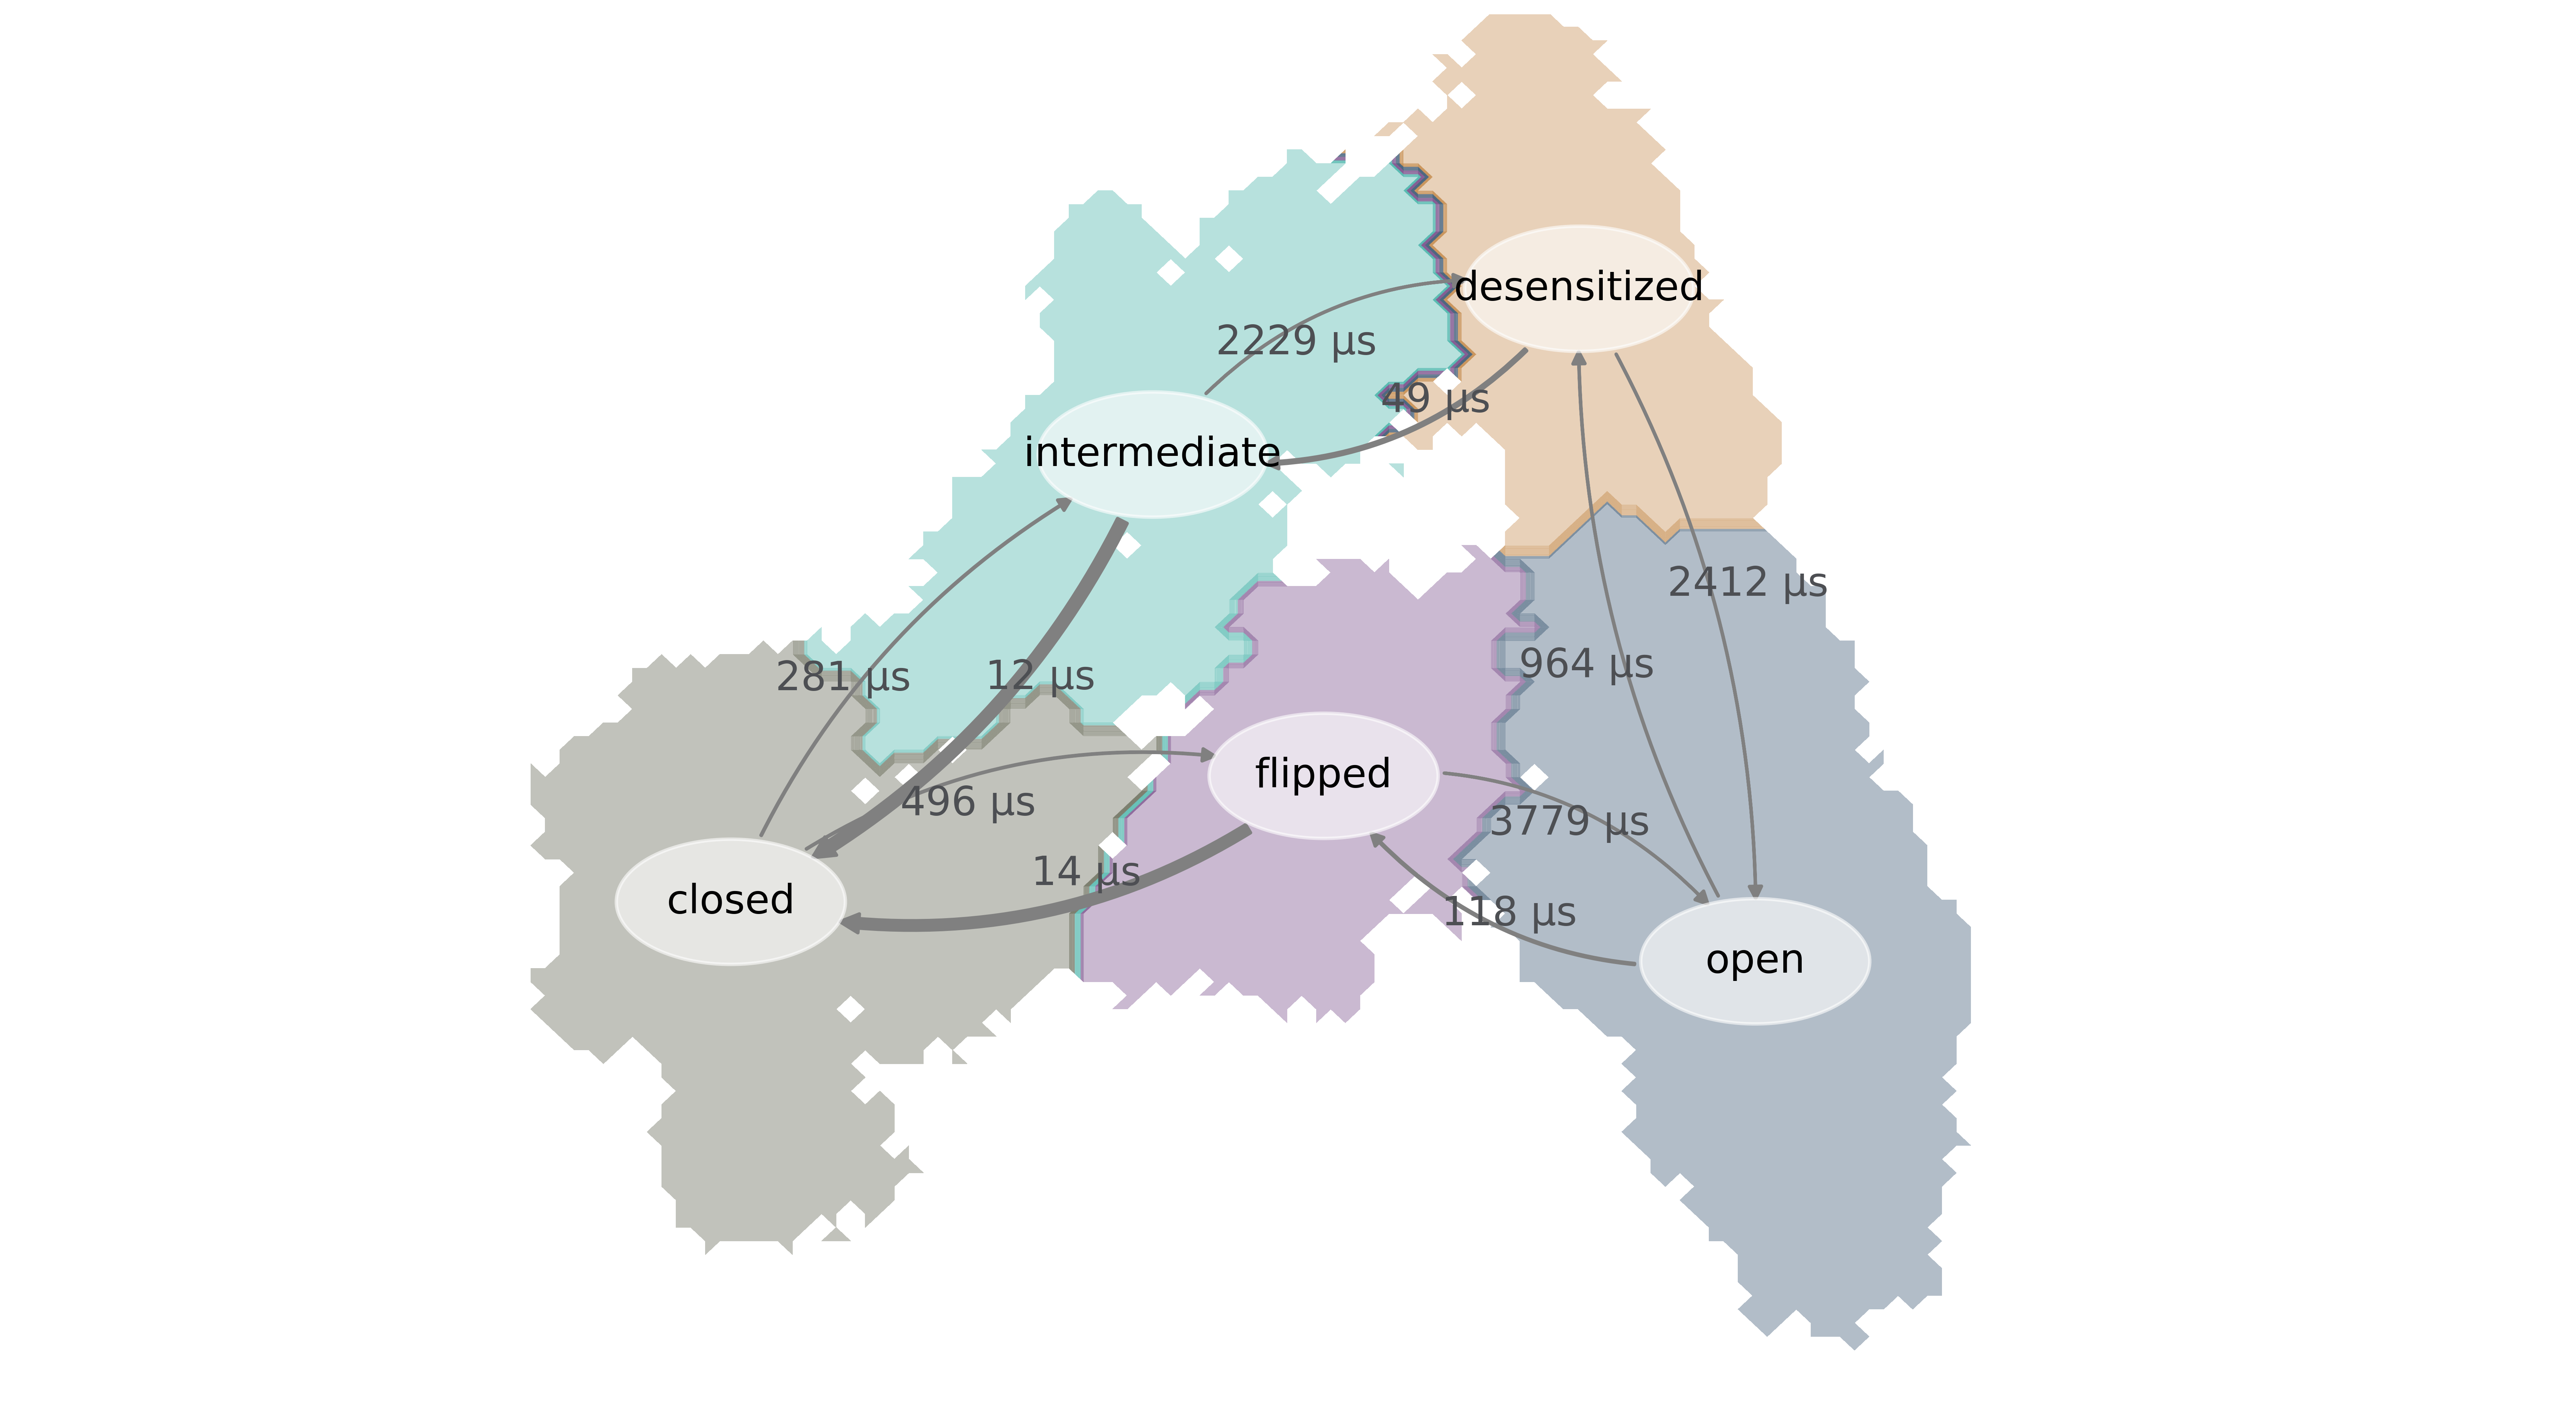

In [78]:
fig, ax = plt.subplots(figsize=(18, 10))

state_colors = [meta_state_color_dict[state_labels[i]] for i in range(n_states)]
state_cmap = matplotlib.colors.ListedColormap(state_colors, name='state')
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, meaningful_tic[:2]].T,
    np.concatenate(metastable_traj),
    cbar=False,
    ax=ax, zorder=-1, cmap=state_cmap)

inverse_mfpt_direct = inverse_mfpt.copy()

inverse_mfpt_direct[0,2] = 0
inverse_mfpt_direct[0,4] = 0
inverse_mfpt_direct[1,3] = 0
inverse_mfpt_direct[1,4] = 0
inverse_mfpt_direct[2,0] = 0
inverse_mfpt_direct[2,3] = 0
inverse_mfpt_direct[3,1] = 0
inverse_mfpt_direct[3,2] = 0
inverse_mfpt_direct[4,0] = 0
inverse_mfpt_direct[4,1] = 0

pyemma.plots.plot_network(
    inverse_mfpt_direct,
    pos=coarse_state_centers,
    figpadding=0,
    state_colors='#ffffff99',
    arrow_label_format='%.0f µs',
    arrow_labels= mfpt / 1000,
    arrow_curvature=2,
    size=20,
    show_frame=False,
    state_labels=[state_labels[i] for i in range(n_states)],
    ax=ax
    )
ax.set_xlim(-6,6)
ax.set_ylim(-5,7)
fig.tight_layout()
plt.savefig('Figures/state_mfpt_pyemma_apo.pdf',bbox_inches = 'tight', pad_inches=0.0, transparent=True)

# Sample Structures from MSM

In [89]:
# feature_apo_msm is generated by md_dataframe.get_feature(md_dataframe.analysis_list)
state_dataframe_msm = pd.read_pickle('data/feature_apo_msm.pickle')

: 

In [ ]:
state_dataframe_msm.head()

In [80]:
def get_centroid(dataframe, tica_inpucluster):
    centers = msm_obj.cluster_centers
    tics = centers.shape[1]
    dataframe[f'dist_to_state_center'] = 0
    for i, center in enumerate(centers):
        tica_input = dataframe[dataframe.n_microstates_1000 == i][[f'tic_{j}' for j in range(1, tics)]].values
        dataframe.loc[dataframe.n_microstates_1000 == i,
                      f'dist_to_state_center'] = np.linalg.norm(tica_input - center,
                                                                axis=1)
    
    dataframe['dist_to_state_center_arg'] = 0
    for i, center in enumerate(centers):
        dataframe.loc[dataframe.n_microstates_1000 == i,
        f'dist_to_state_center_arg'] = np.argsort(np.argsort(dataframe.loc[dataframe.n_microstates_1000 == i,
                                                    f'dist_to_state_center'].values))

    return dataframe

In [81]:
state_dataframe_msm = get_centroid(state_dataframe_msm, cluster)

NameError: name 'plotly_df' is not defined

<Axes: xlabel='tic_1', ylabel='tic_2'>

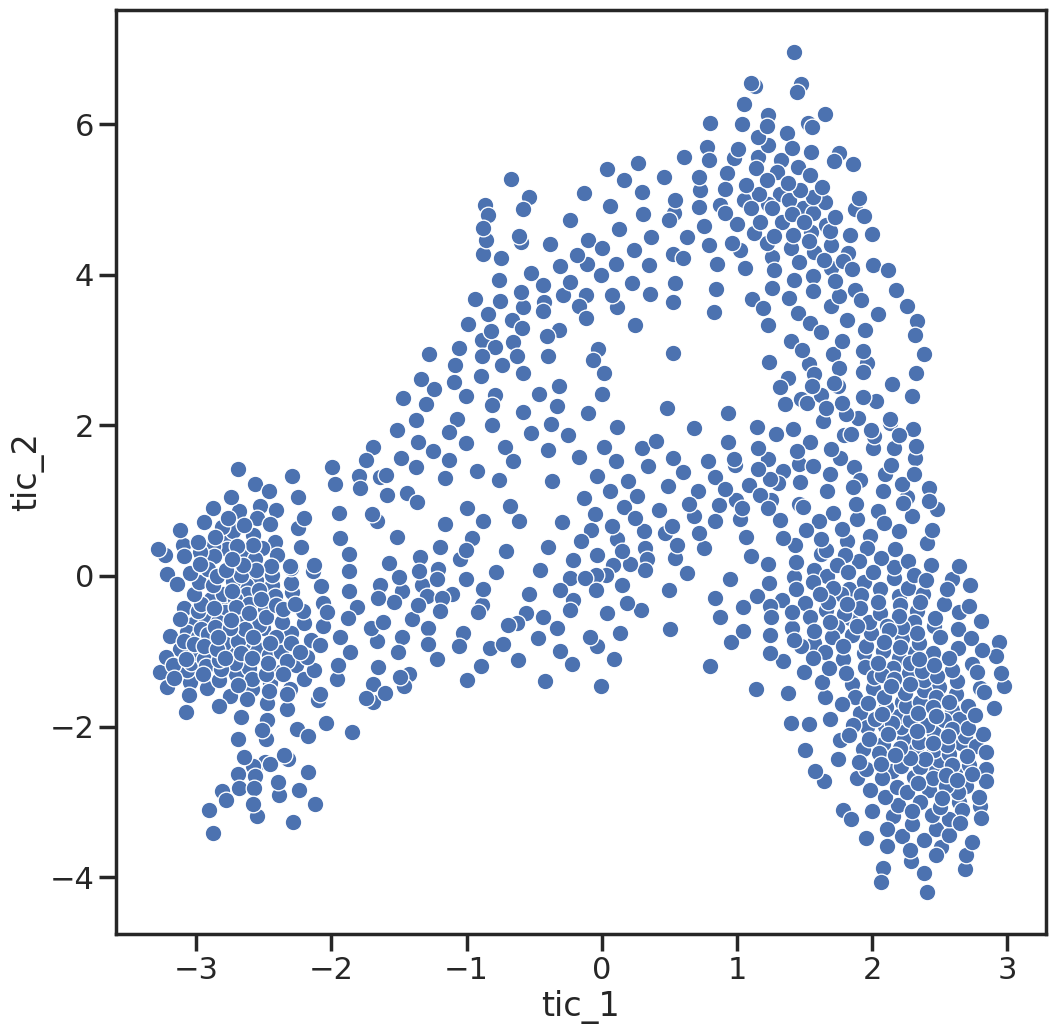

In [33]:
sns.scatterplot(x='tic_1', y='tic_2', data=state_dataframe_msm[state_dataframe_msm.dist_to_state_center_arg == 0])

In [37]:
cluster_rep_frame_df = state_dataframe_msm[state_dataframe_msm.dist_to_state_center_arg == 0].copy()

In [38]:
cluster_rep_frame_df['meta_state'] = msm.metastable_assignments[cluster_rep_frame_df.n_microstates_1000.values]

In [260]:
import pickle
cluster_rep_frame_df = state_dataframe_msm[state_dataframe_msm.dist_to_state_center_arg == 0]

for index, row in tqdm(cluster_rep_frame_df.iterrows(),
                       total=cluster_rep_frame_df.shape[0]):
    universe = pickle.load(open(row.universe_protein, 'rb'))
    # no rot fit transformation
#    universe.trajectory._transformations = universe.trajectory._transformations[:4]
    universe.trajectory[row.frame]
    universe.atoms.write(f'../trajectory/msm_apo/{row.n_microstates_1000}_prot.pdb')

  0%|          | 0/1000 [00:00<?, ?it/s]/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
100%|██████████| 1000/1000 [10:02<00:00,  1.66it/s]


In [47]:
import os
if not os.path.exists('snapshots/snapshots_states.xtc'):
    u = mda.Universe("snapshots/0_prot.pdb",
                    [f"snapshots/{state}_prot.pdb" for state in range(1000)])
    with mda.Writer("snapshots/snapshots_states.xtc", u.atoms.n_atoms) as W:
        for ts in u.trajectory:
            W.write(u.atoms)
else:
    u = mda.Universe("snapshots/0_prot.pdb",
                    "snapshots/snapshots_states.xtc")

In [52]:
state_writer = [mda.Writer(f"snapshots/macro_{i}.xtc", u.atoms.n_atoms) for i in range(nstates)]
for index, row in tqdm(cluster_rep_frame_df.reset_index().iterrows(),
                       total=cluster_rep_frame_df.shape[0]):
    u.trajectory[index]
    state_writer[msm.metastable_assignments[row.n_microstates_1000]].write(u.atoms)

100%|██████████| 1000/1000 [00:03<00:00, 328.49it/s]


In [266]:
simulated_traj = msm.simulate(1000, start=0)

with mda.Writer("snapshots/sim_traj.xtc", u.atoms.n_atoms) as W:
    for state in simulated_traj:
        u.trajectory[state]
        W.write(u.atoms)

Exception ignored in: <function XDRBaseWriter.__del__ at 0x7f15dbad4160>
Traceback (most recent call last):
  File "/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/XDR.py", line 325, in __del__
    self.close()
  File "/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/XDR.py", line 322, in close
    self._xdr.close()
AttributeError: 'XTCWriter' object has no attribute '_xdr'


In [136]:
simulated_traj = msm.simulate(10000, start=0)
np.save('snapshots/sim_traj/sim_traj.npy', simulated_traj)

In [151]:
def initialize_msm_graph():
    inverse_mfpt_direct = inverse_mfpt.copy()

    inverse_mfpt_direct[0,2] = 0
    inverse_mfpt_direct[0,4] = 0
    inverse_mfpt_direct[1,3] = 0
    inverse_mfpt_direct[1,4] = 0
    inverse_mfpt_direct[2,0] = 0
    inverse_mfpt_direct[2,3] = 0
    inverse_mfpt_direct[3,1] = 0
    inverse_mfpt_direct[3,2] = 0
    inverse_mfpt_direct[4,0] = 0
    inverse_mfpt_direct[4,1] = 0
    msm_graph = nx.DiGraph()
    msm_graph.add_nodes_from(state_labels)
    arrow_scale = 1.0 / \
            (np.max(inverse_mfpt_direct - np.diag(np.diag(inverse_mfpt_direct))) * np.sqrt(5))
    for i in range(nstates):
        for j in range(nstates):
            if inverse_mfpt_direct[i,j] > 0:
                msm_graph.add_edge(state_labels[i], state_labels[j],
                                   weight=inverse_mfpt_direct[i,j] * arrow_scale * 10)

    msm_graph = nx.relabel_nodes(msm_graph, {i: state_labels[i] for i in range(nstates)})
    pos = coarse_state_centers
    pos = {state_labels[i]: pos[i] for i in range(nstates)}

    return msm_graph, pos

In [158]:
from time import sleep
import networkx as nx
msm_graph, pos = initialize_msm_graph()
state_colors = [meta_state_color_dict[state_labels[i]] for i in range(nstates)]
state_cmap = matplotlib.colors.ListedColormap(state_colors, name='state')

def plot_current_state(state, macrostate, i, msm_graph, stride):
    fig, ax = plt.subplots(figsize=(15, 10))

    _, _, misc = pyemma.plots.plot_state_map(
        *tica_concatenated[:, meaningful_tic[:2]].T,
        np.concatenate(metastable_traj),
        cbar=False,
        alpha=0.1,
        ax=ax, zorder=-1, cmap=state_cmap)
    
    node_size = [6000 if node == state_labels[macrostate] else 1000 for node in msm_graph.nodes]
    node_alpha = [1 if node == state_labels[macrostate] else 0.2 for node in msm_graph.nodes]
    widths = nx.get_edge_attributes(msm_graph, 'weight')
    nx.draw_networkx_nodes(msm_graph, pos,
                           node_size=node_size,
                           alpha=node_alpha,
                           node_color=state_colors, ax=ax)
    nx.draw_networkx_edges(msm_graph,
                        pos, ax=ax,
                        width=list(widths.values()),
                        edge_color='black',
                        arrowsize=20,
                        connectionstyle='arc3, rad = 0.2')
    nx.draw_networkx_labels(msm_graph, pos, ax=ax, font_size=20,
                            font_color='black', font_weight='bold')
    micro_state_tic_1 = cluster_rep_frame_df[cluster_rep_frame_df.n_microstates_1000 == state].tic_1.values[0]
    micro_state_tic_2 = cluster_rep_frame_df[cluster_rep_frame_df.n_microstates_1000 == state].tic_2.values[0]
    ax.scatter(micro_state_tic_1, micro_state_tic_2, s=500, c='gold', zorder=10, marker='H')
    ax.set_frame_on(False)
    ax.text(x=-4, y=6.05, s=f'Time {i * 0.1 * stride:.0f} µs',)
    return fig, ax
    
stride = 10

#with mda.Writer("snapshots/sim_traj.xtc", u.atoms.n_atoms) as W:
#    for state in simulated_traj[::stride]:
#        u.trajectory[state]
#        W.write(u.atoms)

for i, state in tqdm(enumerate(simulated_traj[::stride]),total=len(simulated_traj[::stride])):
    macro_state = msm.metastable_assignments[state]
    fig, ax = plot_current_state(state, macro_state, i, msm_graph, stride=stride)
    fig.savefig(f'snapshots/sim_traj/traj_{i}.png')
    plt.close()

100%|██████████| 1000/1000 [05:04<00:00,  3.28it/s]


In [ ]:
macro_traj = msm.metastable_assignments[simulated_traj]

In [189]:
with open('snapshots/sim_traj/macro_traj.txt', 'wt') as f:
    for i, state in tqdm(enumerate(macro_traj[::stride]), total=len(macro_traj[::stride])):
        for _ in range(u.atoms.n_atoms-1):
            f.write(f'{state} ')
        f.write(f'{state}')
        # don't write \n at the end of the last line
        if i < len(macro_traj[::stride]) - 1:
            f.write('\n')

100%|██████████| 1000/1000 [00:08<00:00, 114.64it/s]


In [162]:
with mda.Writer("snapshots/sim_traj.xtc", u.atoms.n_atoms) as W:
    for state in simulated_traj[::stride]:
        u.trajectory[state]
        W.write(u.atoms)

In [75]:
state = 1
durations = []

macro_trajs = []
for rep in tqdm(range(1000)):

    # simulate for 0.1s.
    simulated_traj = msm.simulate(100000, start=1, dt=10)
    macro_traj = msm.metastable_assignments[simulated_traj]
    macro_trajs.append(macro_traj)
    
    current_state = None
    duration = 0
    
    # dt is 1 us.
    for time, t in enumerate(macro_traj):
        if t == state:
            if t != current_state:
                duration = 1e-6
                current_state = t
            else:
                duration += 1e-6
        else:
            # if find opening in 300 us
            if state in macro_traj[time:time+300]:
                duration += 1e-6
            else:
                if current_state == state:
                    if duration != 0:
                        durations.append(duration)
                current_state = None
                duration = 0

100%|██████████| 1000/1000 [17:16<00:00,  1.04s/it]


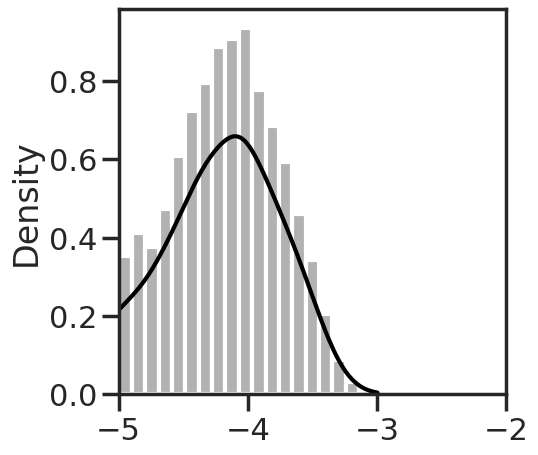

In [90]:
fig, ax = plt.subplots(figsize=(5,5))
durations_log10 = np.log10(np.array(durations))
bins = np.linspace(-5,-2,30)
#ax.hist(durations_log10, bins=bins, density=True, color='black', alpha=0.5)
sns.histplot(durations_log10, ax=ax, color='black', linewidth=3,
        bins=bins, stat='density', alpha=0.3, kde=True, kde_kws={
                                                               'clip': (-5, -2)})
#ax.set_xscale('log')
#ax.set_xlim(1e-6, 1e1)
ax.set_xlim(-5,-2)
plt.savefig('assets/bursting_hist.pdf',bbox_inches = 'tight', pad_inches=0.0, transparent=True)